In [ ]:
from multiinstance.data.gaussian_dg import GaussianMixtureDataGenerator

import numpy as np

from easydict import EasyDict
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score

from multiinstance.nnpu import getPosterior

from dist_curve.transforms import getOptimalTransform

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Lambda, Activation, Concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as KB
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow import summary
import tensorflow.keras.backend as K
import tensorflow as tf

In [ ]:
def generateParams(nClusters, nComps, dim,aucpn_range=[0.8,0.85]):
    posMeans,posCovs,negMeans,negCovs,dgs =[], [],[],[],[]
    for comp in range(nClusters):
        dg = GaussianMixtureDataGenerator(dim,nComps,aucpn_range,1000,10000)
        pos,neg = dg.components_pos[0], dg.components_neg[0]
        r = np.zeros(dim)
        for _ in range(1):
            r += np.random.normal(loc=0,scale=10,size=dim)
        posMeans.append(pos.mean+r)
        posCovs.append(pos.cov)
        negMeans.append(neg.mean+r)
        negCovs.append(neg.cov)
        dgs.append(dg)
    val = EasyDict
    val.posMeans = posMeans
    val.posCovs = posCovs
    val.negMeans = negMeans
    val.negCovs = negCovs
    val.dgs = dgs
    return val

In [ ]:
args = EasyDict()
args.nClusters = 1
args.nComps = 1
args.dim = 32
args.aucpn_range=[0.7,.99]
args.hdim = 1024

In [ ]:
    data = generateParams(args.nClusters, args.nComps, args.dim, args.aucpn_range)

In [ ]:
x,y = data.dgs[0].pn_data(20000,.5)
y = y.astype(bool)[:,0]

In [ ]:
xTrain,xVal,yTrain,yVal = train_test_split(x,y,test_size=.2)

In [ ]:
def train(xTrain,yTrain):
    model = Sequential(name="model")
    model.add(Dense(args.hdim, input_shape=(args.dim,), activation='relu',))
    model.add(Dense(args.hdim, activation='relu',))
    model.add(Dense(args.hdim, activation='relu',))
    model.add(Dense(args.hdim, activation='relu'))
    model.add(Dense(1, activation="sigmoid"))


    model.compile(loss=tf.keras.losses.BinaryCrossentropy())

    model.fit(xTrain,yTrain,epochs=20)
    return model

In [ ]:
model = train(xTrain,yTrain)

Epoch 1/20
500/500 [==============================] - 6s 11ms/step - loss: 0.5910
Epoch 2/20
500/500 [==============================] - 6s 11ms/step - loss: 0.4665
Epoch 3/20
500/500 [==============================] - 6s 12ms/step - loss: 0.4486
Epoch 4/20
500/500 [==============================] - 6s 11ms/step - loss: 0.4321
Epoch 5/20
500/500 [==============================] - 6s 11ms/step - loss: 0.4115
Epoch 6/20
500/500 [==============================] - 6s 11ms/step - loss: 0.4037
Epoch 7/20
500/500 [==============================] - 6s 11ms/step - loss: 0.3871
Epoch 8/20
500/500 [==============================] - 6s 11ms/step - loss: 0.3702
Epoch 9/20
500/500 [==============================] - 6s 11ms/step - loss: 0.3486
Epoch 10/20
500/500 [==============================] - 6s 11ms/step - loss: 0.3398
Epoch 11/20
500/500 [==============================] - 5s 11ms/step - loss: 0.3160
Epoch 12/20
500/500 [==============================] - 6s 11ms/step - loss: 0.2950
Epoch 13/20
5

In [ ]:
roc_auc_score(yVal,model.predict(xVal))

0.809757853213267

In [ ]:
roc_auc_score(yVal, data.dgs[0].pn_posterior_cc(xVal))

0.8735242241828647

In [ ]:
# rnge = np.arange(-20,5,.1)
# plt.plot(rnge,data.dgs[0].pn_posterior(rnge,.5),label="p")
# plt.plot(rnge,data.dgs[0].dens_pos(rnge),label=r"$f_1(x)$")
# plt.plot(rnge,data.dgs[0].dens_neg(rnge),label=r"$f0(x)$")
# plt.plot(rnge,model.predict(rnge.reshape((-1,1))),label="pHat")
# plt.hist(xVal[yVal.astype(bool)],density=True,label="p")
# plt.hist(xVal[~yVal.astype(bool)],density=True,label="n")
# plt.legend()

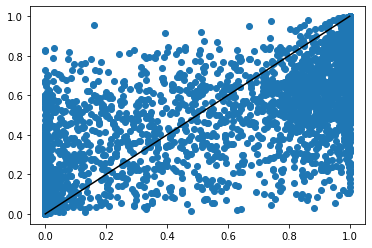

In [ ]:
plt.scatter(model.predict(xVal),data.dgs[0].pn_posterior(xVal,.5))
plt.plot([0,1],[0,1],color="black")

In [ ]:
roc_auc_score(yVal,model.predict(xVal)), roc_auc_score(yVal,data.dgs[0].pn_posterior(xVal,.5))

(0.809757853213267, 0.8735242241828647)

In [ ]:
[xPU,yPU,yPN] = data.dgs[0].pu_data()

In [ ]:
xPUTrain,xPUVal,yPUTrain,yPUVal = train_test_split(xPU,yPU,test_size=.2)
yPUTrain= yPUTrain[:,0].astype(bool)
posTrain = xPUTrain[yPUTrain]
uTrain = xPUTrain[~yPUTrain]
posidxs = np.random.choice(np.arange(posTrain.shape[0]),size=uTrain.shape[0],replace=True)
xpos = posTrain[posidxs]
xPUTrain = np.concatenate((xpos,uTrain))
yPUTrain = np.concatenate((np.ones(uTrain.shape[0]),
                       np.zeros(uTrain.shape[0])))

In [ ]:
model2 = train(xPUTrain,yPUTrain)

Epoch 1/20
500/500 [==============================] - 6s 10ms/step - loss: 0.5894
Epoch 2/20
500/500 [==============================] - 5s 10ms/step - loss: 0.2580
Epoch 3/20
500/500 [==============================] - 5s 10ms/step - loss: 0.1339
Epoch 4/20
500/500 [==============================] - 5s 10ms/step - loss: 0.0857
Epoch 5/20
500/500 [==============================] - 5s 10ms/step - loss: 0.0634
Epoch 6/20
500/500 [==============================] - 5s 10ms/step - loss: 0.0531
Epoch 7/20
500/500 [==============================] - 5s 10ms/step - loss: 0.0412
Epoch 8/20
500/500 [==============================] - 5s 10ms/step - loss: 0.0389
Epoch 9/20
500/500 [==============================] - 5s 10ms/step - loss: 0.0441
Epoch 10/20
500/500 [==============================] - 5s 10ms/step - loss: 0.0349
Epoch 11/20
500/500 [==============================] - 5s 10ms/step - loss: 0.0329
Epoch 12/20
500/500 [==============================] - 5s 10ms/step - loss: 0.0286
Epoch 13/20
5

In [ ]:
roc_auc_score(yPUVal,model2.predict(xPUVal)), roc_auc_score(yPUVal,data.dgs[0].pu_posterior(xPUVal))

(0.8091648335981099, 0.8832615381481934)

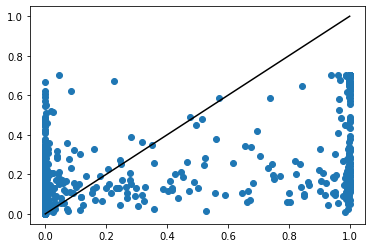

In [ ]:
plt.scatter(model2.predict(xPUVal),
            data.dgs[0].pu_posterior(xPUVal))
plt.plot([0,1],[0,1],color="black")

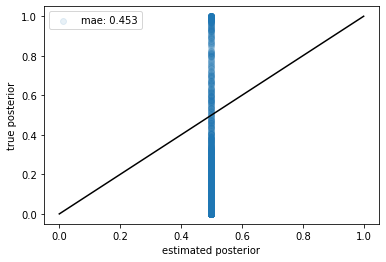

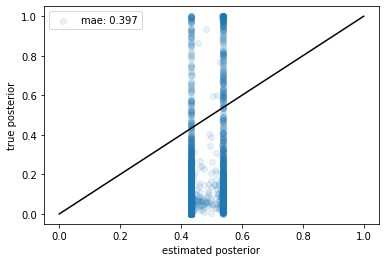

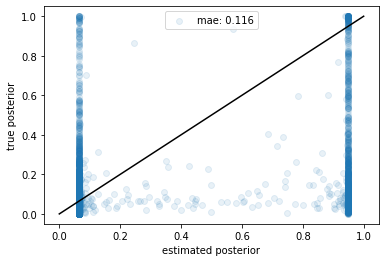

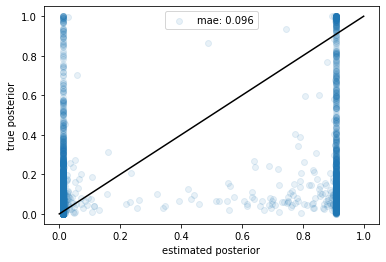

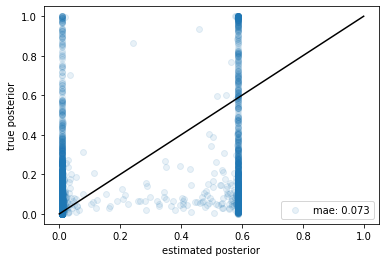

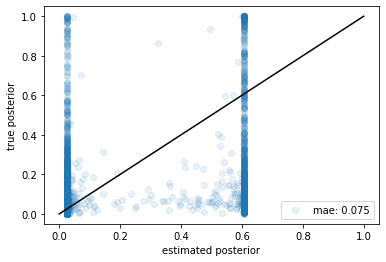

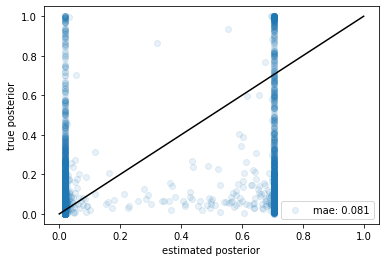

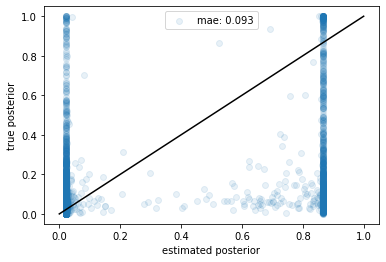

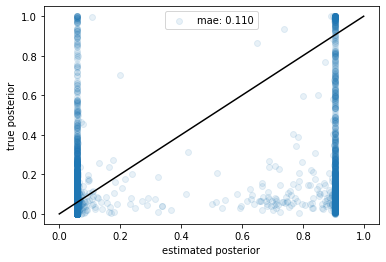

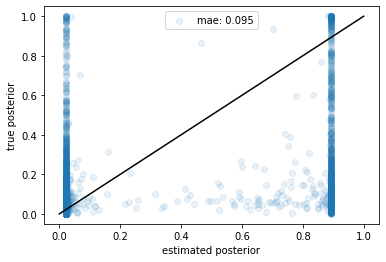

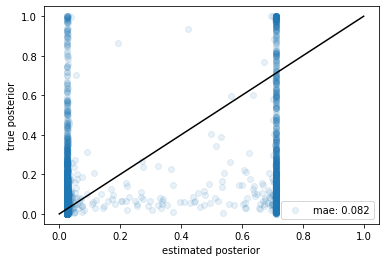

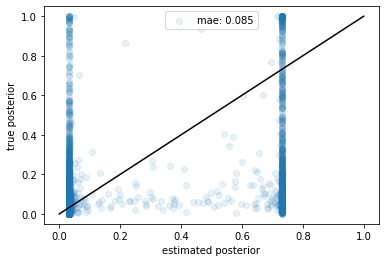

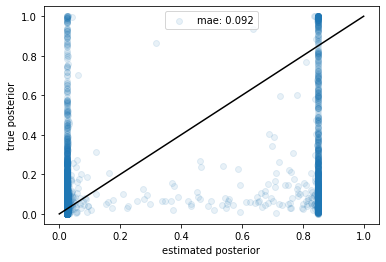

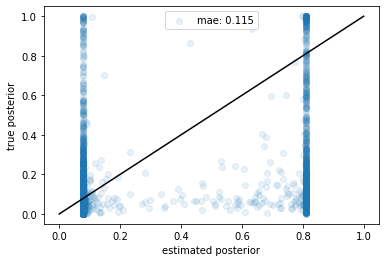

(array([[[0.8105296 ]],
 
        [[0.81050074]],
 
        [[0.81056595]],
 
        ...,
 
        [[0.07876274]],
 
        [[0.07876274]],
 
        [[0.07876274]]], dtype=float32),
 <multiinstance.nnpu.Basic at 0x7f1b5c7620d0>)

In [ ]:
getPosterior(xPU,yPU,data.dgs[0].alpha,inputs=model2.predict(xPU)[:,None],
            distributions=EasyDict({"true_posterior" : data.dgs[0].pn_posterior_cc,
                                     "f1" : data.dgs[0].dens_pos,
                                     "f0" : data.dgs[0].dens_neg}))